# Analyzing simulation data from HOOMD-blue at runtime

The following script shows how to use `freud` to compute the radial distribution function $g(r)$ on data generated by the molecular dynamics simulation engine HOOMD-blue _during a simulation run_.

**Generally, most users will want to run analyses as _post-processing_ steps, on the saved frames of a particle trajectory file.** However, it is possible to use analysis callbacks in HOOMD-blue to compute and log quantities at runtime, too. By using analysis methods at runtime, it is possible to stop a simulation early or change the simulation parameters dynamically according to the analysis results.

HOOMD-blue can be installed with `conda install -c conda-forge hoomd`.

The simulation script runs a Monte Carlo simulation of spheres, with outputs parsed with `numpy.genfromtxt`.

In [1]:
%matplotlib inline
import hoomd
from hoomd import hpmc
import freud
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(
    hoomd.lattice.sc(a=1), n=10)
mc = hpmc.integrate.sphere(seed=42, d=0.1, a=0.1)
mc.shape_param.set('A', diameter=0.5)

rdf = freud.density.RDF(bins=50, r_max=4)
w6 = freud.order.Steinhardt(l=6, wl=True)

def calc_rdf(timestep):
    hoomd.util.quiet_status()
    snap = system.take_snapshot()
    hoomd.util.unquiet_status()
    rdf.compute(system=snap, reset=False)

def calc_W6(timestep):
    hoomd.util.quiet_status()
    snap = system.take_snapshot()
    hoomd.util.unquiet_status()
    w6.compute(system=snap, neighbors={'num_neighbors': 12})
    return np.mean(w6.particle_order)

# Equilibrate the system a bit before accumulating the RDF.
hoomd.run(1e4)
hoomd.analyze.callback(calc_rdf, period=100)

logger = hoomd.analyze.log(filename='output.log',
                           quantities=['w6'],
                           period=100,
                           header_prefix='#',
                           overwrite=True)

logger.register_callback('w6', calc_W6)

hoomd.run(1e4)

# Store the computed RDF in a file
np.savetxt('rdf.csv', np.vstack((rdf.bin_centers, rdf.rdf)).T,
           delimiter=',', header='r, g(r)')

HOOMD-blue v2.7.0-77-g568406147 DOUBLE HPMC_MIXED MPI TBB SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 10/28/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles
** startin

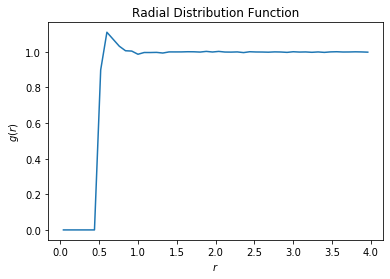

In [3]:
rdf_data = np.genfromtxt('rdf.csv', delimiter=',')
plt.plot(rdf_data[:, 0], rdf_data[:, 1])
plt.title('Radial Distribution Function')
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.show()

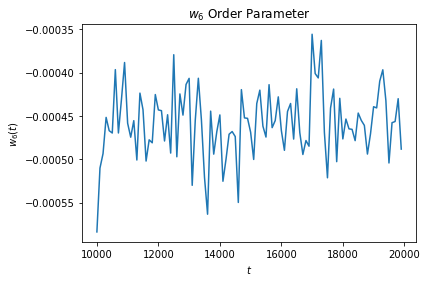

In [4]:
w6_data = np.genfromtxt('output.log')
plt.plot(w6_data[:, 0], w6_data[:, 1])
plt.title('$w_6$ Order Parameter')
plt.xlabel('$t$')
plt.ylabel('$w_6(t)$')
plt.show()